# _IMF Commodity Price Forecast_
***
<b> DESCRIPTION </b>

You are provided with a dataset which consists of Zinc prices for the period Jan 1980 – Feb 2016.

<b>Objective:</b> Obtain a time series model to analyze Zinc prices.

<b>Actions to Perform:</b>

- Visualize the time series
- Check for the stationarity of your data using Rolling Statistics and Dickey-Fuller    test and if present, remove it using the stationarity removal techniques
- Plot ACF and PACF plots. Find the p, d, and q values
- Perform ARIMA modeling
- Forecast the prices using the new model


In [1]:
#load the libraries
import numpy as np
import pandas as pd
#visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#consistent size plots
from pylab import rcParams
rcParams['figure.figsize']=12,5
rcParams['axes.labelsize']=12
rcParams['xtick.labelsize']=12
rcParams['ytick.labelsize']=12
#handle the unwanted warnings
import warnings 
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)
warnings.filterwarnings(action='ignore',category=UserWarning)
#view all the columns
pd.options.display.max_columns = None

In [2]:
#load the zinc time series dataset
zinc = pd.read_csv('zinc_prices_IMF.csv',delimiter=',',parse_dates=True,
                   index_col='Date')
zinc.head()

,Price
Date,
1980-01-01,773.82
1980-02-01,868.62
1980-03-01,740.75
1980-04-01,707.68
1980-05-01,701.07


In [3]:
zinc.tail()

,Price
Date,
2015-10-01,1724.34
2015-11-01,1583.31
2015-12-01,1527.79
2016-01-01,1520.36
2016-02-01,1709.85


_The date is first of every month. In order to work with the time series data, the index has to be marked in certain frequency. In this case, it is the start of every month and hence it should be set to MS_

In [4]:
#set the frequency
zinc.index.freq = 'MS'

In [5]:
#check for any null values in the dataset
zinc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 434 entries, 1980-01-01 to 2016-02-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   434 non-null    float64
dtypes: float64(1)
memory usage: 6.8 KB


In [6]:
zinc.isna().sum()

Price    0
dtype: int64

_There are no null values in the dataset_

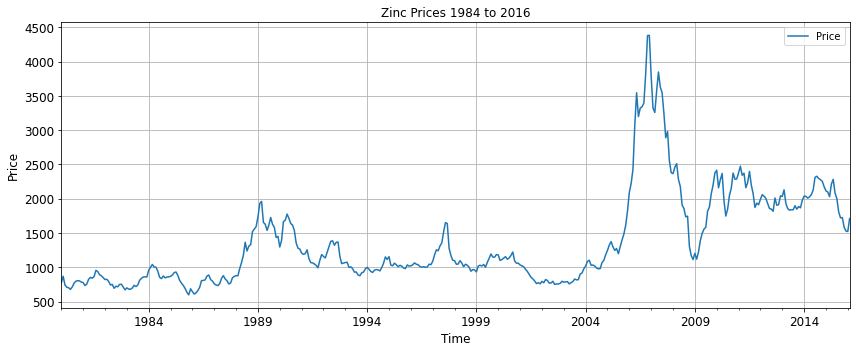

In [7]:
#visualize the zinc prices
zinc.plot()
plt.ylabel('Price')
plt.xlabel('Time')
plt.title('Zinc Prices 1984 to 2016')
plt.tight_layout()
plt.grid()
plt.show()

_Looking at the time series plot, there trend appears to be more of additive in nature rather than multiplicative. This would be necessary to decompose the time series into its elements - Trend, Seasonality and Error components_

## _Exploratory Data Analysis_

### _visualize y versus the lagged version of y_

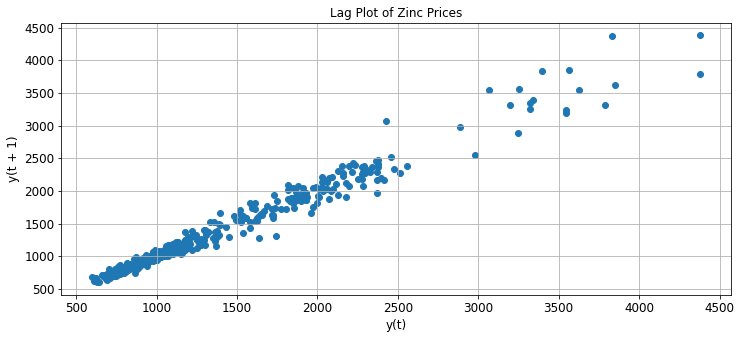

In [8]:
#plot the lag plot
from pandas.plotting import lag_plot
lag_plot(zinc['Price'])
plt.title('Lag Plot of Zinc Prices')
plt.grid()
plt.show()

_The lag plot shows that the neighboring values also increases as y increases. This shows there is a lot of autocorrelation_

### _ACF & PACF_

In [9]:
#import the libraries for plotting ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

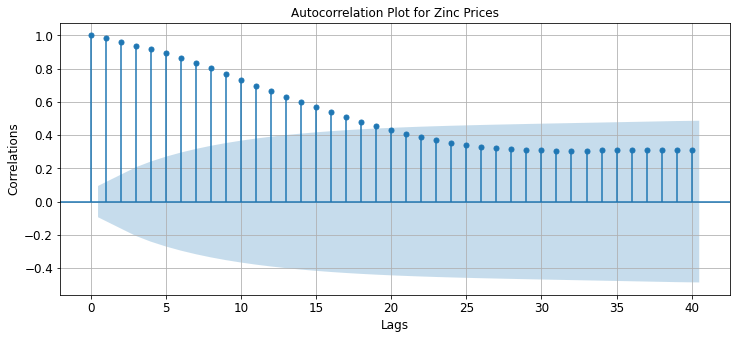

In [10]:
#plot acf 
lags = 40
plot_acf(zinc['Price'],lags=lags)
plt.title('Autocorrelation Plot for Zinc Prices')
plt.ylabel('Correlations')
plt.xlabel('Lags')
plt.grid()
plt.show()

_There is no sharp drop and indicates there is a strong autoregressive component. Also, this is typical of a non stationary data. The shaded area reflects the 95% confidence level. On this plot, there is a significant correlation at lag 1 that decreases after a few lags. This pattern indicates an autoregressive term. Check the partial autocorrelation function to determine the order of the autoregressive term. The MA or q value could be anywhere between 6 to 15_

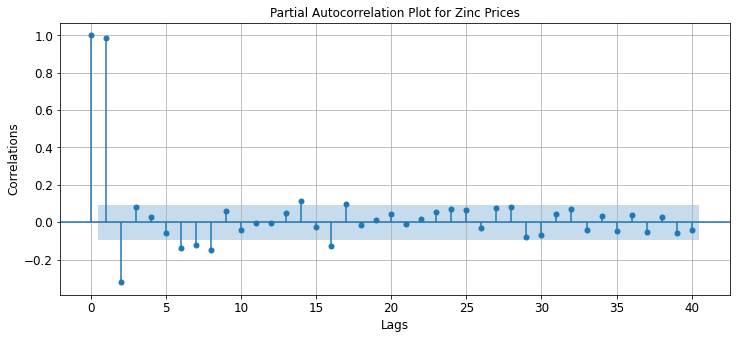

In [11]:
#plot pacf 
lags = 40
plot_pacf(zinc['Price'],lags=lags,use_vlines=True)
plt.title('Partial Autocorrelation Plot for Zinc Prices')
plt.ylabel('Correlations')
plt.xlabel('Lags')
plt.grid()
plt.show()

_Significant correlations at the first or second lag, followed by correlations that are not significant. There could be an autoregressive term of order 1 or 2_

## _Test for Stationarity of the Time Series_

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
#define a function to test for stationrity using Dickey Fuller test
def dickey_fuller(series,title=''):
    '''This is a helper function which performs the dickey fuller test for stationarity of time series.
       Pass a time series and an optional title and see the results'''
    #conduct the test
    print('\n')
    print(f'Augmented Dickey Fuller Test of Stationarity for Time Series {title}')
    print('\n')
    result = adfuller(series.dropna(),autolag='AIC') #dropna will handle any differenced data
    labels =['ADF Test Statistics','p-value','#lags used','# Observations']
    output = pd.Series(result[0:4],index=labels)
    
    for key,value in result[4].items():
        output[f'Critical Value ({key})'] = value
        
    print(output.to_string()) #removes the line dtype xxx
    print('\n')
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")    

In [14]:
#test the stationarity of zic prices times series data
dickey_fuller(zinc['Price'],title='Zinc Price 1984 - 2016')



Augmented Dickey Fuller Test of Stationarity for Time Series Zinc Price 1984 - 2016


ADF Test Statistics      -3.139601
p-value                   0.023758
#lags used                7.000000
# Observations          426.000000
Critical Value (1%)      -3.445794
Critical Value (5%)      -2.868349
Critical Value (10%)     -2.570397


Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [15]:
#import pmdarima --> time series should be stationary to apply this. 
from pmdarima import auto_arima

In [16]:
#perform grid search based on auto arima
stepwise_fit = auto_arima(zinc['Price'], start_p=0, start_q=0,
                          max_p=3, max_q=3, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True) 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5334.837, Time=0.57 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5293.539, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5289.764, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5332.993, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5291.468, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5291.368, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5293.243, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5287.883, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5289.580, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5289.479, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5291.640, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5291.346, Time=0.21 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.072 seconds


In [17]:
#print the summary of the best model
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  434
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2641.942
Date:                Fri, 23 Apr 2021   AIC                           5287.883
Time:                        04:28:24   BIC                           5296.025
Sample:                             0   HQIC                          5291.097
                                - 434                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3314      0.029     11.387      0.000       0.274       0.388
sigma2      1.171e+04    399.469     29.310      0.000    1.09e+04    1.25e+04
===================================================================================
Ljung-Box (Q):                       60.43   Jarque-Bera (JB):               812.95
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               5.39   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<font color=blue> <b> _Clearly from the summary the best order for ARIMA is order(0,1,1)_ </b> </font>

## _Split the dataset into train and test dataset_

In [18]:
#check the length of the data
len(zinc)

434

In [19]:
#split into the train and test data
train_zinc = zinc.iloc[:398]
test_zinc = zinc.iloc[398:]

## _ARIMA Modeling_

In [20]:
#import the libraries for ARIMA modeling
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

In [21]:
model = ARIMA(train_zinc['Price'],order=(0,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                  397
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2426.923
Method:                       css-mle   S.D. of innovations            109.296
Date:                Fri, 23 Apr 2021   AIC                           4859.846
Time:                        04:28:24   BIC                           4871.798
Sample:                    02-01-1980   HQIC                          4864.580
                         - 02-01-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.6194      7.343      0.493      0.622     -10.772      18.011
ma.L1.D.Price     0.3394      0.046      7.373      0.000       0.249       0.430
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -2.9464           +0.0000j            2.9464            0.5000
-----------------------------------------------------------------------------
"""

## _Obtain the Predicted values_

In [22]:
start = len(train_zinc)
end = len(train_zinc) + len(test_zinc) - 1
test_predict = results.predict(start=start,end=end,dynamic=False,typ='levels').rename('ARIMA(0,1,1)')

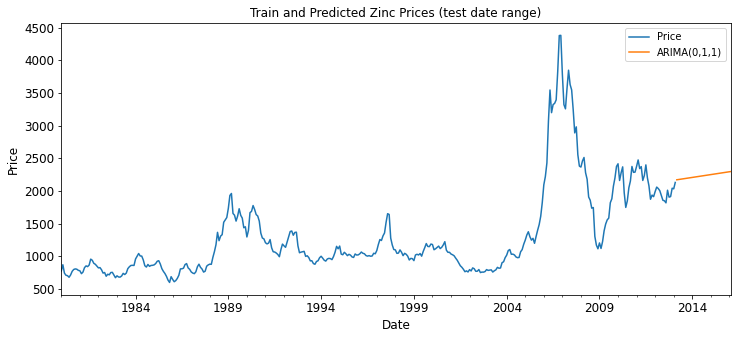

In [23]:
# plot the train and test data
train_zinc.plot(legend=True)
test_predict.plot(legend=True)
plt.title('Train and Predicted Zinc Prices (test date range)')
plt.ylabel('Price')
plt.show()

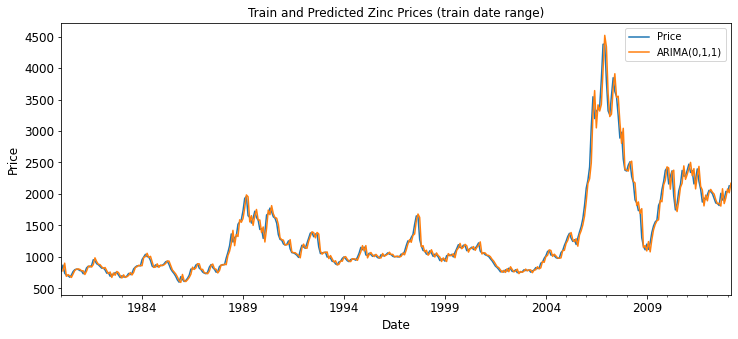

In [26]:
start_train = 1
end_train = len(train_zinc)
train_predict = results.predict(start=start_train,end=end_train,dynamic=False,typ='levels').rename('ARIMA(0,1,1)')
# plot the train prediction
train_zinc.plot(legend=True)
train_predict.plot(legend=True)
plt.title('Train and Predicted Zinc Prices (train date range)')
plt.ylabel('Price')
plt.show()

## _Evaluate the ARIMA Model_

In [ ]:
from statsmodels.tools.eval_measures import mse
from statsmodels.tools.eval_measures import rmse

In [ ]:
print('MSE Zinc Price Predictions')
print(mse(test_zinc['Price'],test_predict))

In [ ]:
print('RMSE Zinc Price Predictions')
print(rmse(test_zinc['Price'],test_predict))

## _Forecast into the real future_

In [ ]:
#forecast 12 points or 1 year into the future .. 
start = len(zinc)
end = len(zinc) + 12

In [ ]:
# fit the ARIMA model on the entire dataset
model = ARIMA(zinc['Price'],order=(0,1,1))
results = model.fit()
results.summary()

In [ ]:
#generate the forecast
forecast = results.predict(start=start,end=end,typ='levels',dynamic=False).rename('ARIMA(0,1,1) Forecast')

In [ ]:
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Zinc Prices Forecasted 12 months into the future'
ylabel ='Price'
xlabel = 'Date' 

ax = zinc['Price'][300:].plot(figsize=(12,5),title=title,legend=True)
ax = forecast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
plt.show()